In [884]:
# libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [885]:
# folders of imported files
folder_std = r'C:\Users\filip\Documents\EPFL\3_sem\ADA\project\P2\MovieSummaries'
folder_add = r'C:\Users\filip\Documents\EPFL\3_sem\ADA\project\P2\Added_df'

In [886]:
# import data. We will use the movie.metadata.tsv file
col_names = ['wikiID','freeID','movie_name','release_date','revenue','runtime','languages','countries','genres']
movies = pd.read_csv(folder_std + "\\movie.metadata.tsv",sep='\t',names=col_names)
movies.sample(20)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres
12281,26272116,/m/04j20jh,Julie Walking Home,2002,NaN,113.0,{},"{""/m/05qhw"": ""Poland"", ""/m/09c7w0"": ""United St...","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""..."
13571,23240836,/m/0660wkr,Raffles,1925-05-24,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/06ppq"": ""Sil..."
81550,20938984,/m/05b45t9,A Visit to the Seaside,1910,NaN,8.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/0jtdp"": ""Docum..."
35802,37017383,/m/0n3_dmf,Cannibal Vegetarian,2012-03-01,NaN,85.0,{},"{""/m/01pj7"": ""Croatia""}","{""/m/07s9rl0"": ""Drama""}"
70064,9264649,/m/0282691,Anarchism in America,1983-01-15,NaN,75.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0jtdp"": ""Documentary""}"
21170,20428509,/m/04zvqs0,Nora's Hair Salon 2: A Cut Above,2007,NaN,80.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/0hj3n0w"": ""Ensembl..."
69331,27997612,/m/04j10d2,"Come On, Cowboys!",1937,NaN,58.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":..."
74707,23580474,/m/06w4fqd,Parasuram,2003,NaN,146.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
35485,31333814,/m/0gj9ly7,The Curse of the Wraydons,1946-12-19,NaN,94.0,{},{},"{""/m/07s9rl0"": ""Drama"", ""/m/03npn"": ""Horror""}"
26611,2171500,/m/06s4qp,Time Out,2001,NaN,133.0,"{""/m/064_8sq"": ""French Language"", ""/m/0f8l9c"":...","{""/m/0f8l9c"": ""France""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster..."


In [887]:
# the column release date is set to be a datetime object. We have two different formats. we solve this using a mask
release_date = pd.to_datetime(movies['release_date'],errors='coerce')
mask = release_date.isna()
second_format = pd.to_datetime(movies['release_date'][mask],format='%Y',errors='coerce')
release_date[mask] = second_format
movies['release_date'] = release_date

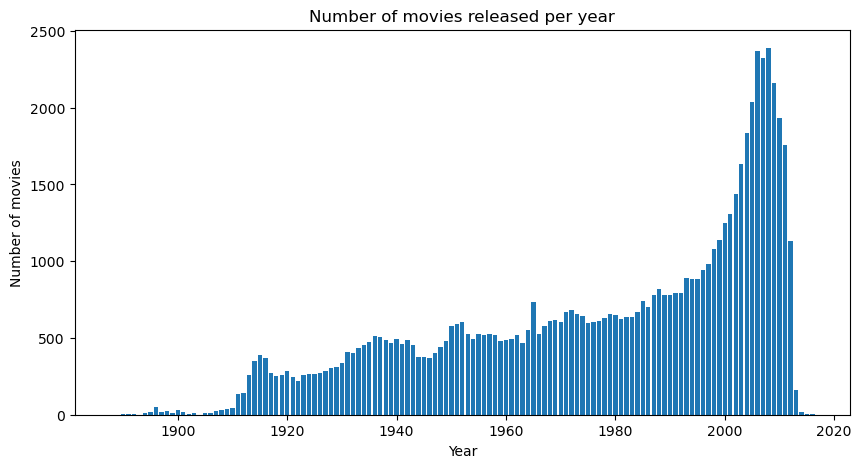

In [888]:
# we want to plot the number of movies released per year
# we group by year and count the number of movies
yearly_movies = movies.groupby(movies['release_date'].dt.year)['release_date'].count().reset_index(name='count')


# plot the number of movies per year
plt.figure(figsize=(10,5))
plt.bar(yearly_movies['release_date'],yearly_movies['count'])
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Number of movies released per year')
plt.show()

In [889]:
# we want to know how many movies were released before and after the year 2001, since this is the year of the twin towers attack
count_before2001 = yearly_movies[yearly_movies['release_date']<2001]['count'].sum()
count_after2001 = yearly_movies[yearly_movies['release_date']>=2001]['count'].sum()
print(f'Movies before the year 2001 are {count_before2001}')
print(f'Movies after the year 2001 are {count_after2001}')
print(f'The ratio of movies after the year 2001 is {count_after2001/(count_after2001+ count_before2001):.2}')  

Movies before the year 2001 are 49056
Movies after the year 2001 are 22488
The ratio of movies after the year 2001 is 0.31


The twin tower event has a relevant amount of films before (arounf 69%) and after (31%). This is a first sign that we can work analysing it through movies. 
Now we preprocess some colums to be simpler to handle

In [890]:
# treating the countries column
import json

def extract_value(json_string):
    try:
        if json_string == '{}':
            return 'NaN'
        # Parse the JSON string into a dictionary
        data = json.loads(json_string)
        
        # Extract the values (assuming there's only one key-value pair in the dictionary)
        value = list(data.values())
        
        return value
    except json.JSONDecodeError:
        # Handle the case where the input string is not a valid JSON
        return 'NaN'



In [891]:
# we apply the function to the countries, genres and language columns
movies['countries'] = movies['countries'].apply(lambda x : extract_value(x))

# we want to plot the number of movies per country
movies['genres'] = movies['genres'].apply(lambda x : extract_value(x))

# we want to plot the number of movies per country
movies['languages'] = movies['languages'].apply(lambda x : extract_value(x))

In [892]:
movies.countries.iloc[395]

['France', 'Spain']

Now, to really study arab actors, we read the actors df and work on the ethnicities.

In [893]:
# Read the character.metadata.tsv file
col_names = ['wikiID','freeID','release_date','character_name','birth','gender','height','ethnicity_code', 'actor_name', 'age_at_release', 'freeID_character_actor_map', 'freeID_character', 'freeID_actor']
characters= pd.read_csv(open(folder_std + "\\character.metadata.tsv",encoding='utf-8'), delimiter="\t", names=col_names)

characters.head()

,wikiID,freeID,release_date,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


We use a merge to join movies and character dataframes. We use the freeID and wikiID, (identifiers for movies) as keys

In [894]:
# merge the two dataframes on the wikiID and freeID
movies_characters = pd.merge(movies, characters, on=['freeID', 'wikiID'], how='inner', suffixes=('', '_y'))

# we drop the duplicate columns
movies_characters=movies_characters.drop(['release_date_y'], axis=1)
movies_characters.columns

# arab_people=movies_characters[movies_characters['etnicity']== 'arab'].groupby('movienames')

Index(['wikiID', 'freeID', 'movie_name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'character_name', 'birth', 'gender',
       'height', 'ethnicity_code', 'actor_name', 'age_at_release',
       'freeID_character_actor_map', 'freeID_character', 'freeID_actor'],
      dtype='object')

In [895]:
movies_characters.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


We want to study the ethnicity column. Analysing the freebase ID we want to get who is arab

In [896]:
# print the number of Actor ethnicities (Freebase ID)
eth_num = movies_characters['ethnicity_code'].unique().shape[0]
print(f'There are {eth_num} different ethnicities')


There are 480 different ethnicities


How to decode the Freebase ID to a prcise ethnicity? We used a query command to the freebase API and got a database to work on.

In [897]:
# read the csv file where we decode the ethnicities ID
ethnicity_decode = pd.read_csv(folder_add + "\\ethnicity.csv",sep=',')
ethnicity_decode.columns= ['ethnicity_code', 'ethnicity_name']
ethnicity_decode.head()

,ethnicity_code,ethnicity_name
0,/m/07s8n27,Makonde people
1,/m/02k1vf,Powhatan
2,/m/0630vt,Apalachee people
3,/m/038cy,Germanic peoples
4,/m/03gq7tt,Hän people


In [898]:
# merging the two dataframes
movies_characters_eth= pd.merge(movies_characters, ethnicity_decode, how='left', left_on=['ethnicity_code'], right_on=['ethnicity_code'])
movies_characters_eth.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


Did the ethnicity_decode work for all the freebase ID?


In [899]:
# filter the movies that have an eyhnicity_code but not the ethnicity_name
not_filtered= movies_characters_eth[ movies_characters_eth['ethnicity_code'].notna() * movies_characters_eth['ethnicity_name'].isna() ].copy()
print(f'characters not decoded: {not_filtered.shape[0]}')
print(f'portion of characters not decoded: {not_filtered.shape[0]/movies_characters_eth.shape[0]:.2}')

eth_not_decoded=not_filtered['ethnicity_code'].unique().shape[0]

eth_not_decoded_portion= eth_not_decoded/ movies_characters_eth['ethnicity_code'].unique().shape[0]
not_filtered['ethnicity_code'].unique().shape[0]

print(f'ethnicities not decoded {eth_not_decoded}')
print(f'portion of ethnicities not decoded {eth_not_decoded_portion:.2}')


characters not decoded: 50587
portion of characters not decoded: 0.11
ethnicities not decoded 158
portion of ethnicities not decoded 0.33


We wanna understand the portion of characters wiyh an ethnicity name and get an yearly plot

In [900]:
# fraction of characters that have not a ethnicity_name, per year
# we group by year and count the number of characters

yearly_characters= movies_characters_eth.groupby(movies_characters_eth['release_date'].dt.year)['release_date'].count().reset_index(name='charaters')
# characters with ethnicity

yearly_characters_w_eth_name= movies_characters_eth.groupby(movies_characters_eth['release_date'].dt.year)['ethnicity_name'].count().reset_index(name='charaters_weth_name')
yearly_characters_w_eth_code= movies_characters_eth.groupby(movies_characters_eth['release_date'].dt.year)['ethnicity_code'].count().reset_index(name='charaters_weth_code')

# merge the two dataframes
yearly_characters= pd.merge(yearly_characters, yearly_characters_w_eth_name, how='left', left_on=['release_date'], right_on=['release_date'])
yearly_characters= pd.merge(yearly_characters, yearly_characters_w_eth_code, how='left', left_on=['release_date'], right_on=['release_date'])
yearly_characters.head()


,release_date,charaters,charaters_weth_name,charaters_weth_code
0,1888.0,4,0,0
1,1891.0,1,1,1
2,1893.0,2,0,0
3,1894.0,4,1,1
4,1895.0,1,0,0


Text(0, 0.5, 'Number of characters')

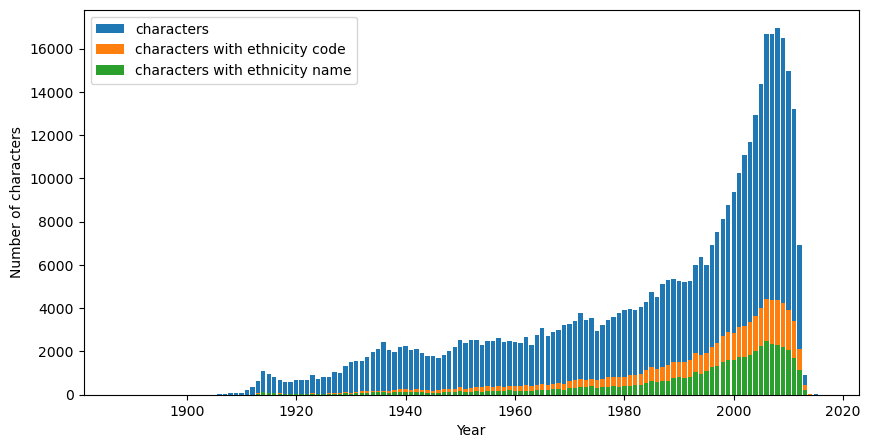

In [901]:
#plot 
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['charaters'], label='characters')
plt.bar(yearly_characters['release_date'],yearly_characters['charaters_weth_code'], label='characters with ethnicity code')
plt.bar(yearly_characters['release_date'],yearly_characters['charaters_weth_name'], label='characters with ethnicity name')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of characters')

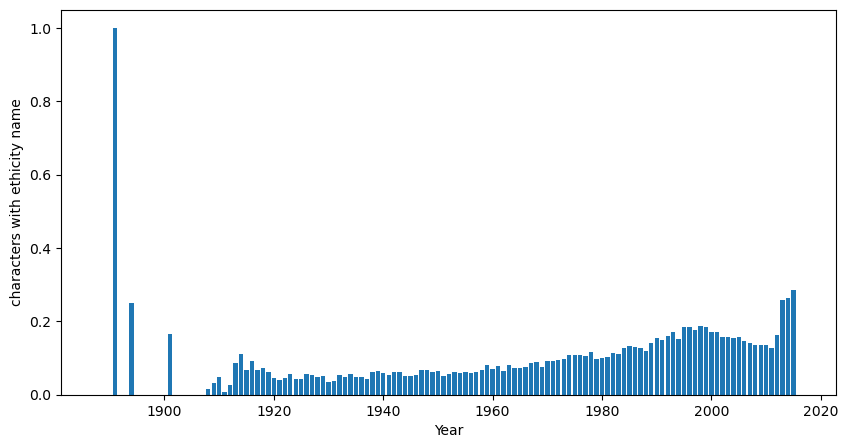

In [902]:
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['charaters_weth_name']/yearly_characters['charaters'])
plt.xlabel('Year')
plt.ylabel('characters with ethicity name')
plt.show()  

We can conclude that a small yearly proportion of characters has a ethnicity name. Now let's analyse arabs between these ethnicities

In [903]:
# count the frequency for ethnicity names
eth_count= movies_characters_eth.groupby(['ethnicity_name']).size().reset_index(name='count')
eth_count=eth_count.sort_values(by='count', ascending=False)

eth_count=eth_count.set_index(['ethnicity_name'])
eth_count.head(20)


,count
ethnicity_name,
African Americans,10159
English people,6165
Italian Americans,2956
White Americans,2250
Scottish American,2223
Irish people,1637
Tamil,1215
Punjabis,1155
Malayali,1146


In [904]:
# unique ethnicities
eth_unique=eth_count.index.unique()
print(eth_unique.shape[0])

# Commonly associated Muslim ethnicities. we used Chat GPT results
muslim_ethnicities = ['Punjabis', 'Malayali', 'Bengali people', 'Telugu people', 'Gujarati people', 'Pashtuns', 'Sri Lankan Tamils', 'Bihari people', 'Bengali Hindus', 'Kannada people', 'Kurdish', 'Tibetan people', 'Pakistani American', 'Muhajir']
arab_ethnicities = ['Punjabis', 'Bengali people', 'Pashtuns', 'Sri Lankan Tamils', 'Bihari people', 'Sindhis', 'Kashmiri people', 'Afghans in India', 'Iranians', 'Albanian American', 'Syrian Americans', 'Moroccan Jews', 'Kurdish', 'Iraqi Americans', 'Turkish Americans', 'Lebanese Americans', 'Iranians in the United Kingdom', 'Palestinian American', 'Moroccan Americans', 'Egyptian Americans', 'Libyan Americans', 'Algerian Americans', 'Tunisian Americans', 'Yemeni Americans', 'Saudi Americans', 'Omani Americans', 'Emirati Americans', 'Qatari Americans', 'Kuwaiti Americans', 'Bahraini Americans', 'Jordanian Americans', 'Palestinians', 'Rohingya people', 'Malays', 'Indonesians', 'Bangladeshis', 'Pakistanis', 'Turks', 'Persians', 'Arabs']
# manually deleted: 'Gujarati peole'
# dubious about: 'Punjabis'

# Filter ethnicities corresponding to Muslim people
muslim_ethnicities_subset = list(np.intersect1d(eth_unique, muslim_ethnicities))
arab_ethnicities_subset = list(np.intersect1d(eth_unique, arab_ethnicities))

# we got two subsets, one 
print(len(muslim_ethnicities_subset), muslim_ethnicities_subset)
print(len(arab_ethnicities_subset), arab_ethnicities_subset)

# Select only the ethnicity name of eth_unique in the arab_ethnicities_subset
arab_count=eth_count.loc[arab_ethnicities_subset].reset_index().copy()
arab_count=arab_count.sort_values(by='count', ascending=False)
arab_count.head(50)

320
13 ['Bengali Hindus', 'Bengali people', 'Bihari people', 'Gujarati people', 'Kannada people', 'Malayali', 'Muhajir', 'Pakistani American', 'Pashtuns', 'Punjabis', 'Sri Lankan Tamils', 'Telugu people', 'Tibetan people']
20 ['Afghans in India', 'Albanian American', 'Arabs', 'Bengali people', 'Bihari people', 'Iranians', 'Iranians in the United Kingdom', 'Iraqi Americans', 'Kashmiri people', 'Lebanese Americans', 'Moroccan Americans', 'Moroccan Jews', 'Palestinian American', 'Pashtuns', 'Persians', 'Punjabis', 'Sindhis', 'Sri Lankan Tamils', 'Syrian Americans', 'Turkish Americans']


,ethnicity_name,count
15,Punjabis,1155
3,Bengali people,868
16,Sindhis,314
13,Pashtuns,188
17,Sri Lankan Tamils,180
4,Bihari people,148
0,Afghans in India,130
1,Albanian American,121
9,Lebanese Americans,91
5,Iranians,79


Now, we have a list of ethnicity names linked to the arab population. we want to understand the percestage respect to the total posupation and the yearly distribution

In [905]:
# proportion of arab characters
print(f'proportion of arab characters {arab_count["count"].sum()*100/eth_count["count"].sum():.3}%')

proportion of arab characters 6.4%


In [906]:
#filter only arab characters
movies_characters_eth_ar=movies_characters_eth[movies_characters_eth['ethnicity_name'].isin(arab_ethnicities_subset)]
movies_characters_eth_ar.head()

# count the number of arab characters per year
yearly_characters_ar= movies_characters_eth_ar.groupby(movies_characters_eth_ar['release_date'].dt.year)['release_date'].count().reset_index(name='charaters_ar')
yearly_characters= pd.merge(yearly_characters, yearly_characters_ar, how='left', left_on=['release_date'], right_on=['release_date'])

# substitute the nan values with 0
yearly_characters=yearly_characters.fillna(0)
yearly_characters.head()

,release_date,charaters,charaters_weth_name,charaters_weth_code,charaters_ar
0,1888.0,4,0,0,0.0
1,1891.0,1,1,1,0.0
2,1893.0,2,0,0,0.0
3,1894.0,4,1,1,0.0
4,1895.0,1,0,0,0.0


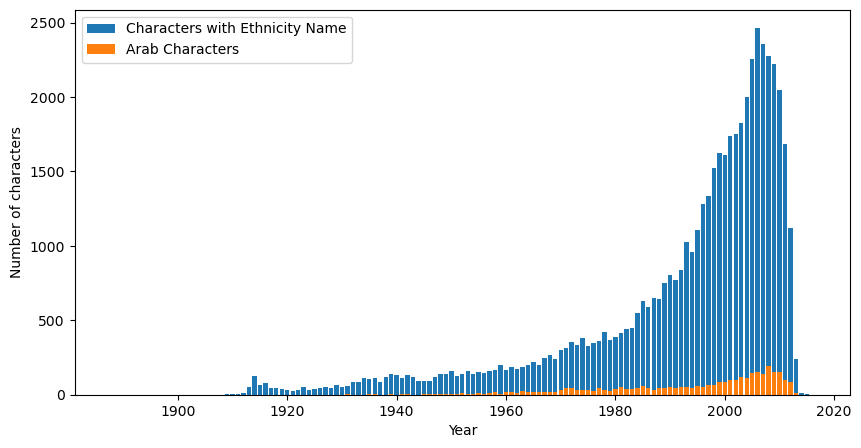

In [907]:
# plot the characters with an ethnicity and the characters with arab 
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['charaters_weth_name'], label='Characters with Ethnicity Name')
plt.bar(yearly_characters['release_date'],yearly_characters['charaters_ar'], label='Arab Characters')
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.legend()
plt.show()

In [908]:
# arabs pre and post 2001
arab_post_2001=yearly_characters[yearly_characters['release_date']>2001]['charaters_ar'].sum()
arab_pre_2001=yearly_characters[yearly_characters['release_date']<=2001]['charaters_ar'].sum()
print(f'Arab characters before 2001: {arab_pre_2001}')
print(f'Arab characters after 2001: {arab_post_2001}')

Arab characters before 2001: 1861.0
Arab characters after 2001: 1447.0


Now, we would like to distinguish the films from the US respect to the others

In [909]:
# For the general country count, since movie can have more than one country, we select only the first one.
movies_characters_eth_ar['first_country']=movies_characters_eth_ar['countries'].apply(lambda x: x[0])
yearly_country= movies_characters_eth_ar.groupby([movies_characters_eth_ar['release_date'].dt.year, movies_characters_eth_ar['first_country']]).size().reset_index(name='count')

# for the USA case, we filter the movies that have USA as a country
movies_characters_eth_ar_USA=movies_characters_eth_ar[movies_characters_eth_ar['countries'].apply(lambda x: 'United States of America' in x)]
yearly_country_USA=movies_characters_eth_ar_USA.groupby(movies_characters_eth_ar_USA['release_date'].dt.year).size().reset_index(name='charaters_ar_USA')
yearly_country_USA.head()

#we add then this column to the yearly_characters dataframe
yearly_characters= pd.merge(yearly_characters, yearly_country_USA, how='left', left_on=['release_date'], right_on=['release_date']).fillna(0)

C:\Users\filip\AppData\Local\Temp\ipykernel_32720\3256020020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_characters_eth_ar['first_country']=movies_characters_eth_ar['countries'].apply(lambda x: x[0])


Before 2001: 188
After 2001: 237


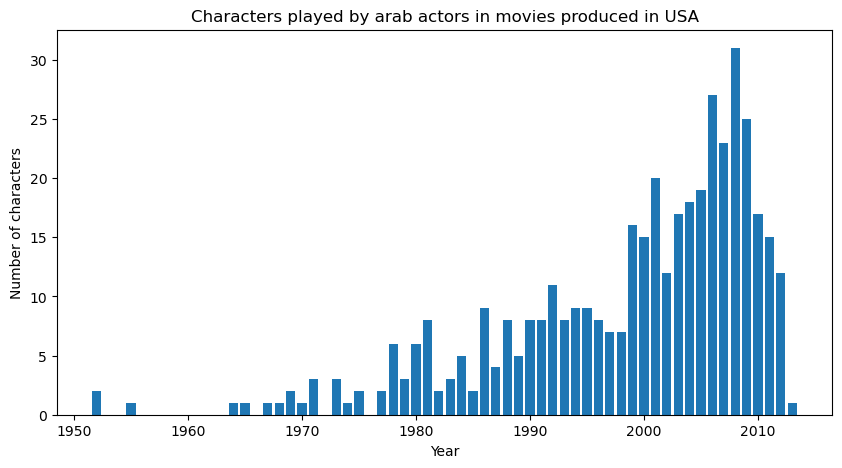

In [910]:
# plot
plt.figure(figsize=(10,5))
plt.bar(yearly_country_USA['release_date'],yearly_country_USA['charaters_ar_USA'])
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Characters played by arab actors in movies produced in USA')

# print pre and post 2001
arab_post_2001=yearly_country_USA[yearly_country_USA['release_date']>=2001]['charaters_ar_USA'].sum()
arab_pre_2001=yearly_country_USA[yearly_country_USA['release_date']<2001]['charaters_ar_USA'].sum()
print(f'Before 2001: {arab_pre_2001}')
print(f'After 2001: {arab_post_2001}')

Now, we want to understand if there is the character named in the text summary plot. We take every movie character for the USA.

In [911]:
# import the plot summaries
plot_summaries = pd.read_csv(folder_std + "\\plot_summaries.txt",sep='\t',names=['wikiID','summary'])
plot_summaries.head()

,wikiID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [912]:
# merge the two dataframes
movies_characters_ar_USA_sum= pd.merge(movies_characters_eth_ar_USA, plot_summaries, how='left', left_on=['wikiID'], right_on=['wikiID'])
movies_characters_ar_USA_sum.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,...,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name,first_country,summary
0,24863901,/m/09gnwkp,1 a Minute,2010-01-01,NaN,90.0,[English Language],[United States of America],[Documentary],Cancer Survivor,...,1.63,/m/0bpjh3,Lisa Ray,37.0,/m/09j46wf,/m/0h0ynpp,/m/07brgk,Bengali people,United States of America,The film is a hybrid between narrative structu...
1,24863901,/m/09gnwkp,1 a Minute,2010-01-01,NaN,90.0,[English Language],[United States of America],[Documentary],Actress/Breast Cancer Survivor,...,1.70,/m/04nrnz,Mumtaz,62.0,/m/0h2v1zq,/m/0h2l643,/m/06s6xv,Iranians,United States of America,The film is a hybrid between narrative structu...
2,7572051,/m/0kvbmd,Made Men,1999-01-01,NaN,90.0,NaN,[United States of America],"[Action/Adventure, Action, Gangster Film, Comedy]",NaN,...,1.80,/m/0ffhz3,Jim Belushi,44.0,/m/04hvddk,NaN,/m/01wyzyl,Albanian American,United States of America,NaN
3,20713032,/m/052172r,Bhopal: Prayer for Rain,2012-01-01,NaN,NaN,[English Language],"[United States of America, India, United Kingdom]","[Disaster, Drama]",Choudhury,...,NaN,/m/0cm7w1,Vineet Kumar,54.0,/m/0b6vvbs,/m/0h779kp,/m/027lhzz,Bihari people,United States of America,The film follows multiple characters' lives an...
4,8610844,/m/0279xlz,Three Violent People,NaT,1200000.0,99.0,[English Language],[United States of America],"[Western, Family Drama, Drama, Period piece]",NaN,...,NaN,/m/0g48m4,Jamie Farr,NaN,/m/02vcm8b,NaN,/m/0mb_6,Lebanese Americans,United States of America,Confederate soldier Capt. Colt Saunders comes ...


In [913]:
# function to check if a name is in the text. In this case we are looking for the name of the characters in the plot summaries.

def is_in_text(name_and_sur, text):
    # we split name_and_sur in its parts, name, possible surname or added names/titles and we make them lower case
    name_and_sur_list = [name.lower() for name in name_and_sur.split(' ')]
    # we make the text lower case
    text = text.lower()
    for name in name_and_sur_list:
        if name in text:
            return True
    return False

is_in_text( 'fILIPPO/brignolo', 'Filip Babic is a student at EPFL')

False

In [914]:
# we filter the values that are not Nan for character name and summary columns.
filter_nan = movies_characters_ar_USA_sum[['character_name', 'summary']].notna().all(axis=1)
movies_characters_ar_USA_sum = movies_characters_ar_USA_sum[filter_nan]

# we apply the function to the dataframe and we add a column with the result, if the character name is in the summary
movies_characters_ar_USA_sum['char_inplot']=movies_characters_ar_USA_sum.apply(lambda x : is_in_text(x['character_name'], x['summary']), axis=1)
movies_characters_ar_USA_sum.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,...,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name,first_country,summary,char_inplot
0,24863901,/m/09gnwkp,1 a Minute,2010-01-01,NaN,90.0,[English Language],[United States of America],[Documentary],Cancer Survivor,...,/m/0bpjh3,Lisa Ray,37.0,/m/09j46wf,/m/0h0ynpp,/m/07brgk,Bengali people,United States of America,The film is a hybrid between narrative structu...,False
1,24863901,/m/09gnwkp,1 a Minute,2010-01-01,NaN,90.0,[English Language],[United States of America],[Documentary],Actress/Breast Cancer Survivor,...,/m/04nrnz,Mumtaz,62.0,/m/0h2v1zq,/m/0h2l643,/m/06s6xv,Iranians,United States of America,The film is a hybrid between narrative structu...,False
3,20713032,/m/052172r,Bhopal: Prayer for Rain,2012-01-01,NaN,NaN,[English Language],"[United States of America, India, United Kingdom]","[Disaster, Drama]",Choudhury,...,/m/0cm7w1,Vineet Kumar,54.0,/m/0b6vvbs,/m/0h779kp,/m/027lhzz,Bihari people,United States of America,The film follows multiple characters' lives an...,False
5,23467297,/m/06w8b2n,Perfect Mismatch,2009-07-10,NaN,97.0,[English Language],"[United States of America, India]","[Romantic comedy, World cinema, Drama, Comedy,...",Neha D. Patel,...,/m/0bpjh3,Nandana Sen,41.0,/m/06wkw5g,/m/0h4zgj1,/m/0ff6p1,Bengali people,United States of America,"{{Peacock}} Mr. Bhalla , a hyper-vibrant Punja...",True
9,25981715,/m/08n3t7v,Saint John of Las Vegas,NaT,102647.0,85.0,[English Language],[United States of America],"[Road movie, Black comedy, Drama, Comedy, Indie]",Tasty D Lite,...,/m/0640_7q,Emmanuelle Chriqui,NaN,/m/08n3tsm,/m/0gy8yz5,/m/05qfpl,Moroccan Jews,United States of America,A compulsive gambler attempts to cure his addi...,True


In [915]:
char_percent = movies_characters_ar_USA_sum['char_inplot'].sum()/movies_characters_ar_USA_sum.shape[0]
print(f'Percentage of characters in the summary: {char_percent:.3}')
print(f'Number of characters in the summary: {movies_characters_ar_USA_sum["char_inplot"].sum()}')
print(f'Number of characters not in the summary: {movies_characters_ar_USA_sum.shape[0]-movies_characters_ar_USA_sum["char_inplot"].sum()}')

Percentage of characters in the summary: 0.639
Number of characters in the summary: 154
Number of characters not in the summary: 87


In [916]:
# add the yearly arab characters in movies pubblished in USA, present in the summary
yearly_characters_ar_USA_inplot=movies_characters_ar_USA_sum.groupby(movies_characters_ar_USA_sum['release_date'].dt.year)['char_inplot'].sum().reset_index(name='characters_ar_USA_inplot')
yearly_characters_ar_USA_inplot.head()

yearly_characters=yearly_characters.merge(yearly_characters_ar_USA_inplot, how='left', left_on=['release_date'], right_on=['release_date']).fillna(0)
yearly_characters.head()

,release_date,charaters,charaters_weth_name,charaters_weth_code,charaters_ar,charaters_ar_USA,characters_ar_USA_inplot
0,1888.0,4,0,0,0.0,0.0,0.0
1,1891.0,1,1,1,0.0,0.0,0.0
2,1893.0,2,0,0,0.0,0.0,0.0
3,1894.0,4,1,1,0.0,0.0,0.0
4,1895.0,1,0,0,0.0,0.0,0.0


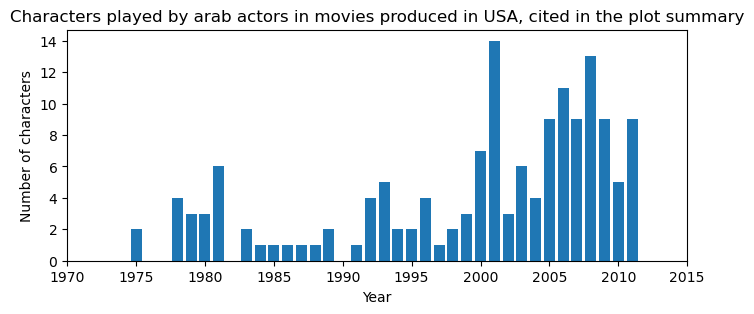

Characters in the summary before 2001: 72.0
Characters in the summary after 2001: 78.0


In [930]:
# Plot the yearly number of arab characters in movies pubblished in USA, present in the summary
plt.figure(figsize=(8,3))
plt.bar(yearly_characters['release_date'],yearly_characters['characters_ar_USA_inplot'])
plt.xlim(1970,2015)
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Characters played by arab actors in movies produced in USA, cited in the plot summary')
plt.show()

print(f'Characters in the summary before 2001: {yearly_characters[yearly_characters["release_date"]<=2001]["characters_ar_USA_inplot"].sum()}')
print(f'Characters in the summary after 2001: {yearly_characters[yearly_characters["release_date"]>2001]["characters_ar_USA_inplot"].sum()}')

In [918]:
'''
yearly_runtime=movies.groupby(movies['release_date'].dt.year)['runtime'].mean()

movies['runtime'].describe()
plt.figure(figsize=(10,5))
sns.boxplot(y=movies['runtime'], x=movies['release_date'].dt.year)
plt.yscale('log')
plt.ylim(10, 500)
plt.xticks(np.arange(0, len(yearly_movies), 10))
plt.ylabel('Runtime')
plt.title('Boxplot of runtime')
plt.show()

'''

"\nyearly_runtime=movies.groupby(movies['release_date'].dt.year)['runtime'].mean()\n\nmovies['runtime'].describe()\nplt.figure(figsize=(10,5))\nsns.boxplot(y=movies['runtime'], x=movies['release_date'].dt.year)\nplt.yscale('log')\nplt.ylim(10, 500)\nplt.xticks(np.arange(0, len(yearly_movies), 10))\nplt.ylabel('Runtime')\nplt.title('Boxplot of runtime')\nplt.show()\n\n"

In [919]:

'''
import pandas as pd
import json
types= pd.read_csv(folder + "\\tvtropes.clusters.txt", sep='\t', header=None, names=["type", "column_name"])


types['column_name']= types["column_name"].apply(lambda x: json.loads(x))


types_norm = pd.json_normalize(types['column_name'])


types_new= pd.concat([types, types_norm], axis=1)
types_new= types_new.drop(['column_name'], axis=1)
types_new.head()

typecast= types_new.groupby(['actor', 'type'])['movie'].count().reset_index(name='count')
typecast.head()
'''

'\nimport pandas as pd\nimport json\ntypes= pd.read_csv(folder + "\\tvtropes.clusters.txt", sep=\'\t\', header=None, names=["type", "column_name"])\n\n\ntypes[\'column_name\']= types["column_name"].apply(lambda x: json.loads(x))\n\n\ntypes_norm = pd.json_normalize(types[\'column_name\'])\n\n\ntypes_new= pd.concat([types, types_norm], axis=1)\ntypes_new= types_new.drop([\'column_name\'], axis=1)\ntypes_new.head()\n\ntypecast= types_new.groupby([\'actor\', \'type\'])[\'movie\'].count().reset_index(name=\'count\')\ntypecast.head()\n'

In [920]:

'''
print(typecast [typecast['count'] > 1].shape[0])
typecast [typecast['count'] > 1]
'''

"\nprint(typecast [typecast['count'] > 1].shape[0])\ntypecast [typecast['count'] > 1]\n"